In [25]:
%matplotlib inline
import numpy as np
import pandas as pd 
import os
import json
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 14
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
top_row_dict = lambda in_df: list(in_df.head(1).T.to_dict().values())[0]

### Total Categories

In [26]:
obj_files = glob(os.path.join('./quickdraw_simplified/', '*.ndjson'))
print(len(obj_files))

345


In [27]:
c_json = pd.read_json(obj_files[0], lines = True, chunksize = 1)
f_row = next(c_json)
f_dict = top_row_dict(f_row)
f_row

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[18, 16, 23, 65, 98, 108, 118, 140, 145, 145...",4939782322913280,True,2017-01-26 14:14:31.929500,strawberry


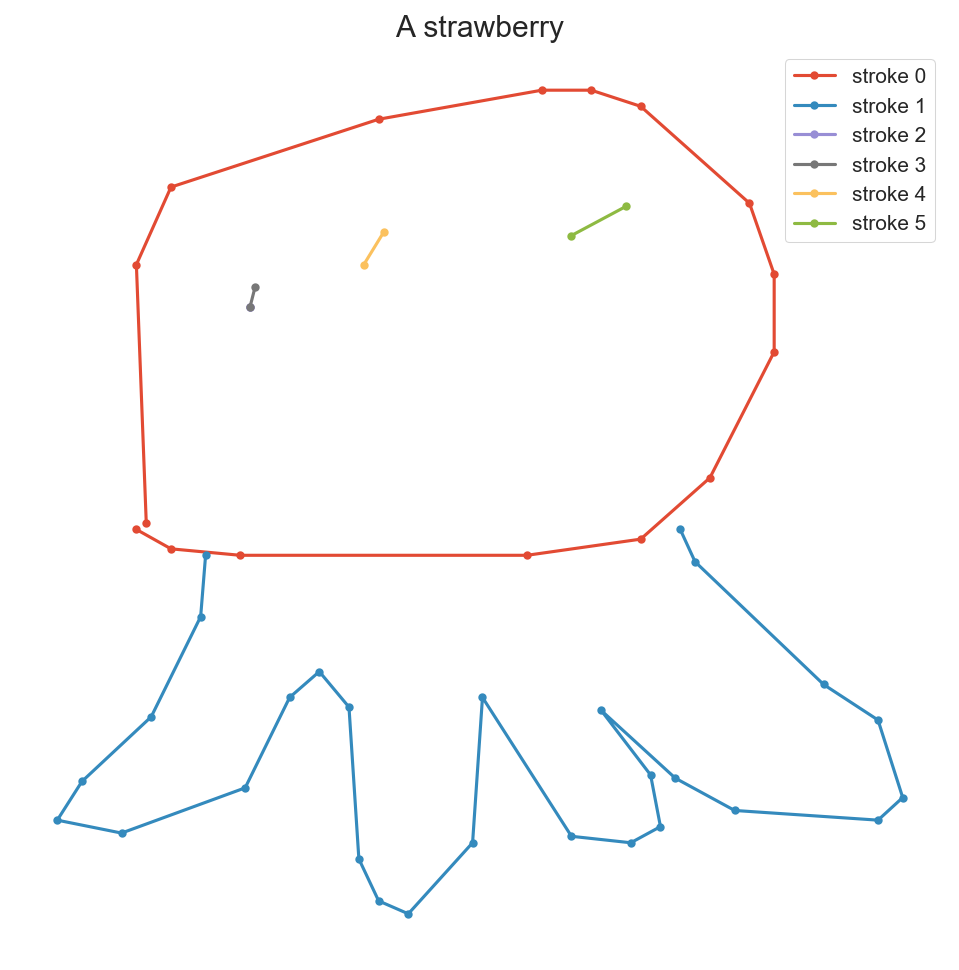

In [28]:
def draw_dict(in_dict, in_ax, legend = True):
    for i, (x_coord, y_coord) in enumerate(in_dict['drawing']):
        in_ax.plot(x_coord, y_coord, '.-', label = 'stroke {}'.format(i))
    if legend:
        in_ax.legend()
    in_ax.set_title('A {word}'.format(**in_dict))
    in_ax.axis('off')
fig, ax1 = plt.subplots(1, 1, figsize = (8,8))
draw_dict(f_dict, ax1)

In [29]:
def multi_ndjson_gen(paths, shuffle = True):
    json_readers = [pd.read_json(c_path, lines = True, chunksize = 1) for c_path in paths]
    while True:
        if shuffle:
            np.random.shuffle(json_readers)
        for c_reader in json_readers:
            yield top_row_dict(next(c_reader))
nd_gen = multi_ndjson_gen(obj_files)

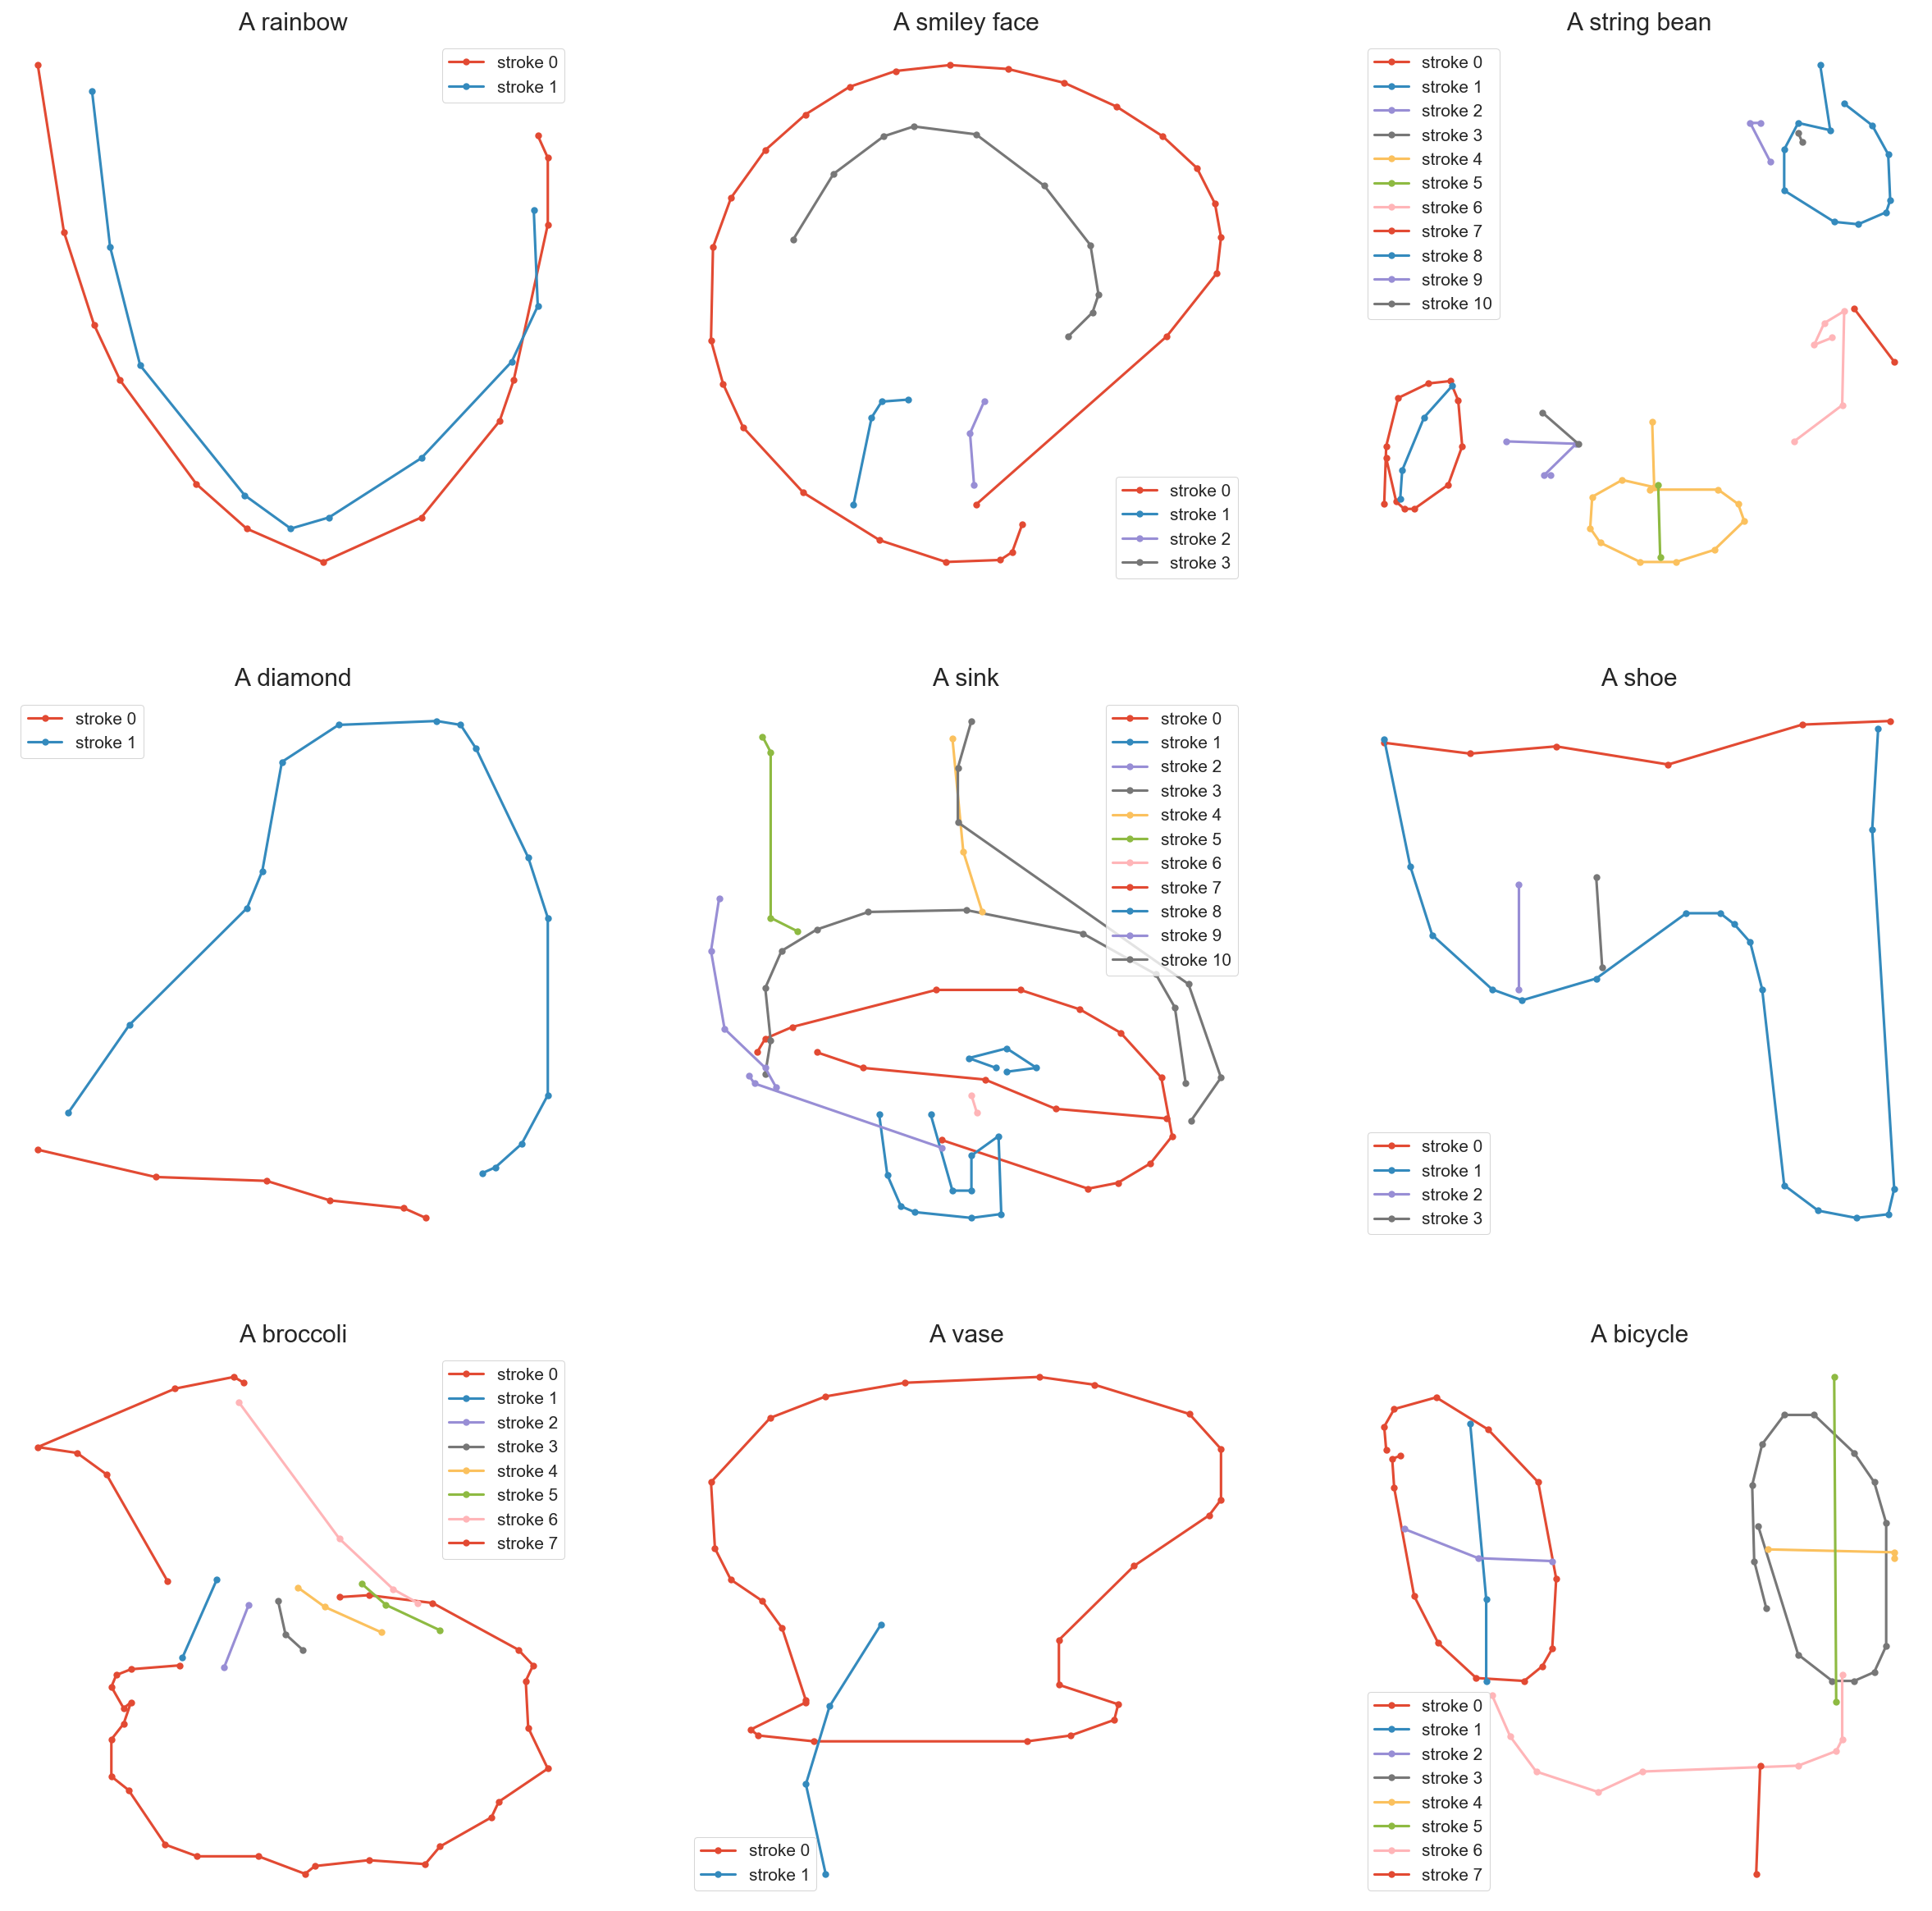

In [30]:
fig, m_axs = plt.subplots(3, 3, figsize = (20,20))
for f_dict, c_ax in zip(nd_gen, m_axs.flatten()):
    draw_dict(f_dict, c_ax)

Text(0.5, 1.05, 'Low Resolution')

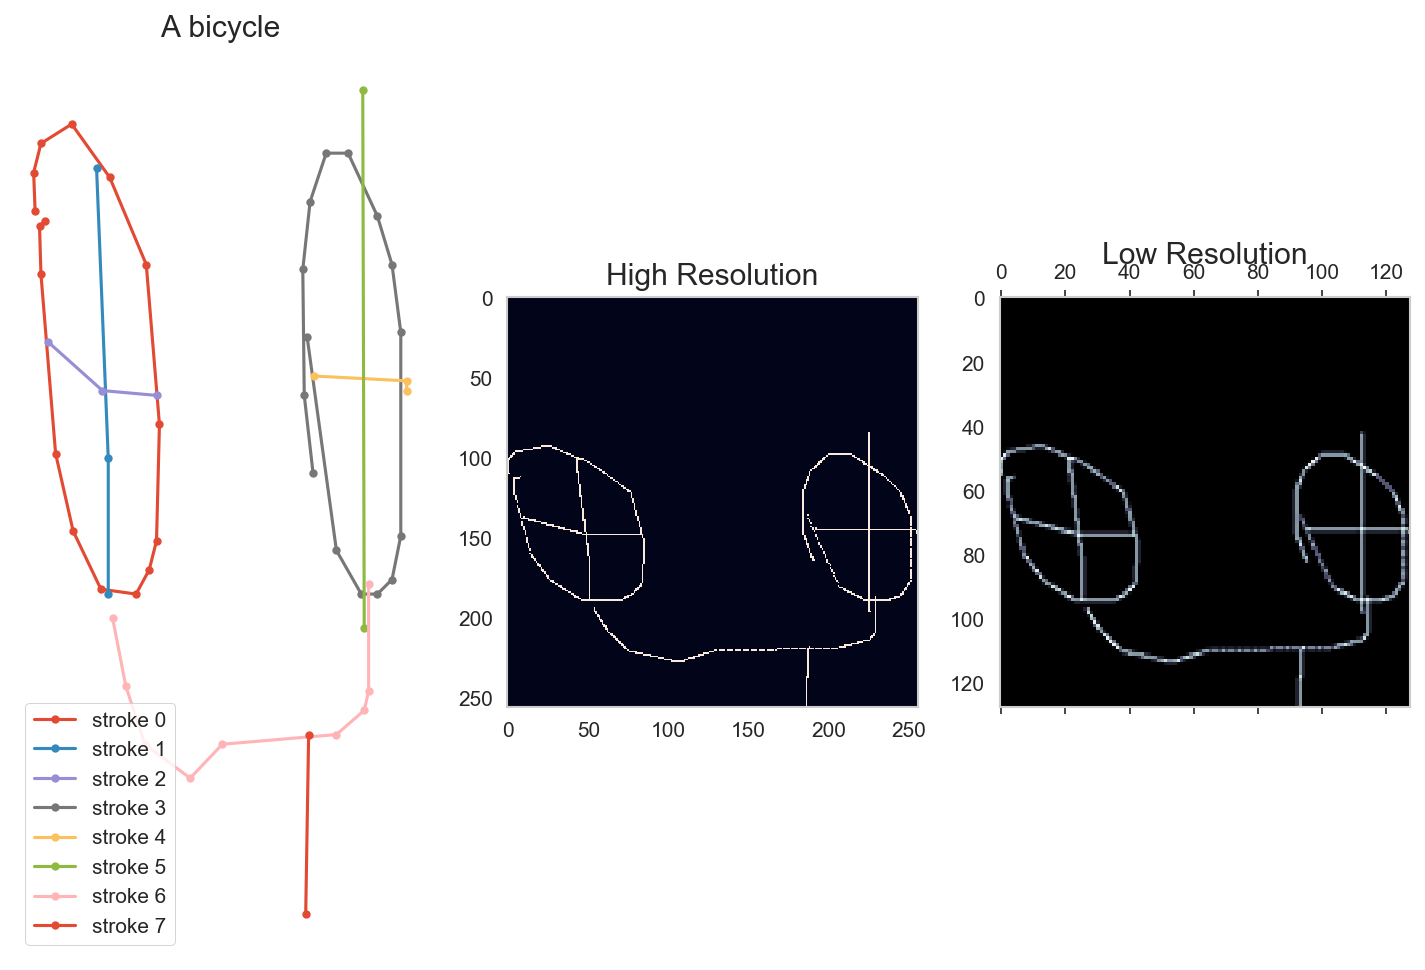

In [31]:
from PIL import Image
def strokes_to_mat(in_strokes, out_dims = (256, 256), rescale_dims = None, resample_points = 500):
    base_img = np.zeros(out_dims, dtype = np.float32)
    # TODO: 1d interpolation is a bad strategy here, should be improved to something that makes more sense
    rs_points = lambda x_pts, out_dim: np.interp(np.linspace(0, 1, resample_points),
                                        np.linspace(0, 1, len(x_pts)), 
                                        np.array(x_pts)/256.0*out_dim).astype(int)
    for (x_coord, y_coord) in in_strokes:
        rx_coord = rs_points(x_coord, out_dims[1])
        ry_coord = out_dims[0]-1-rs_points(y_coord, out_dims[0])
        base_img[ry_coord, rx_coord] = 1.0
    if rescale_dims is not None:
        base_img = np.array(Image.fromarray(base_img).resize(rescale_dims, 
                                                             resample = Image.BICUBIC))
    return base_img

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,8))
draw_dict(f_dict, ax1)
ax2.imshow(strokes_to_mat(f_dict['drawing']))
ax2.set_title('High Resolution')
ax3.matshow(strokes_to_mat(f_dict['drawing'], rescale_dims = (128, 128)), vmin = 0, cmap = 'bone')
ax3.set_title('Low Resolution')

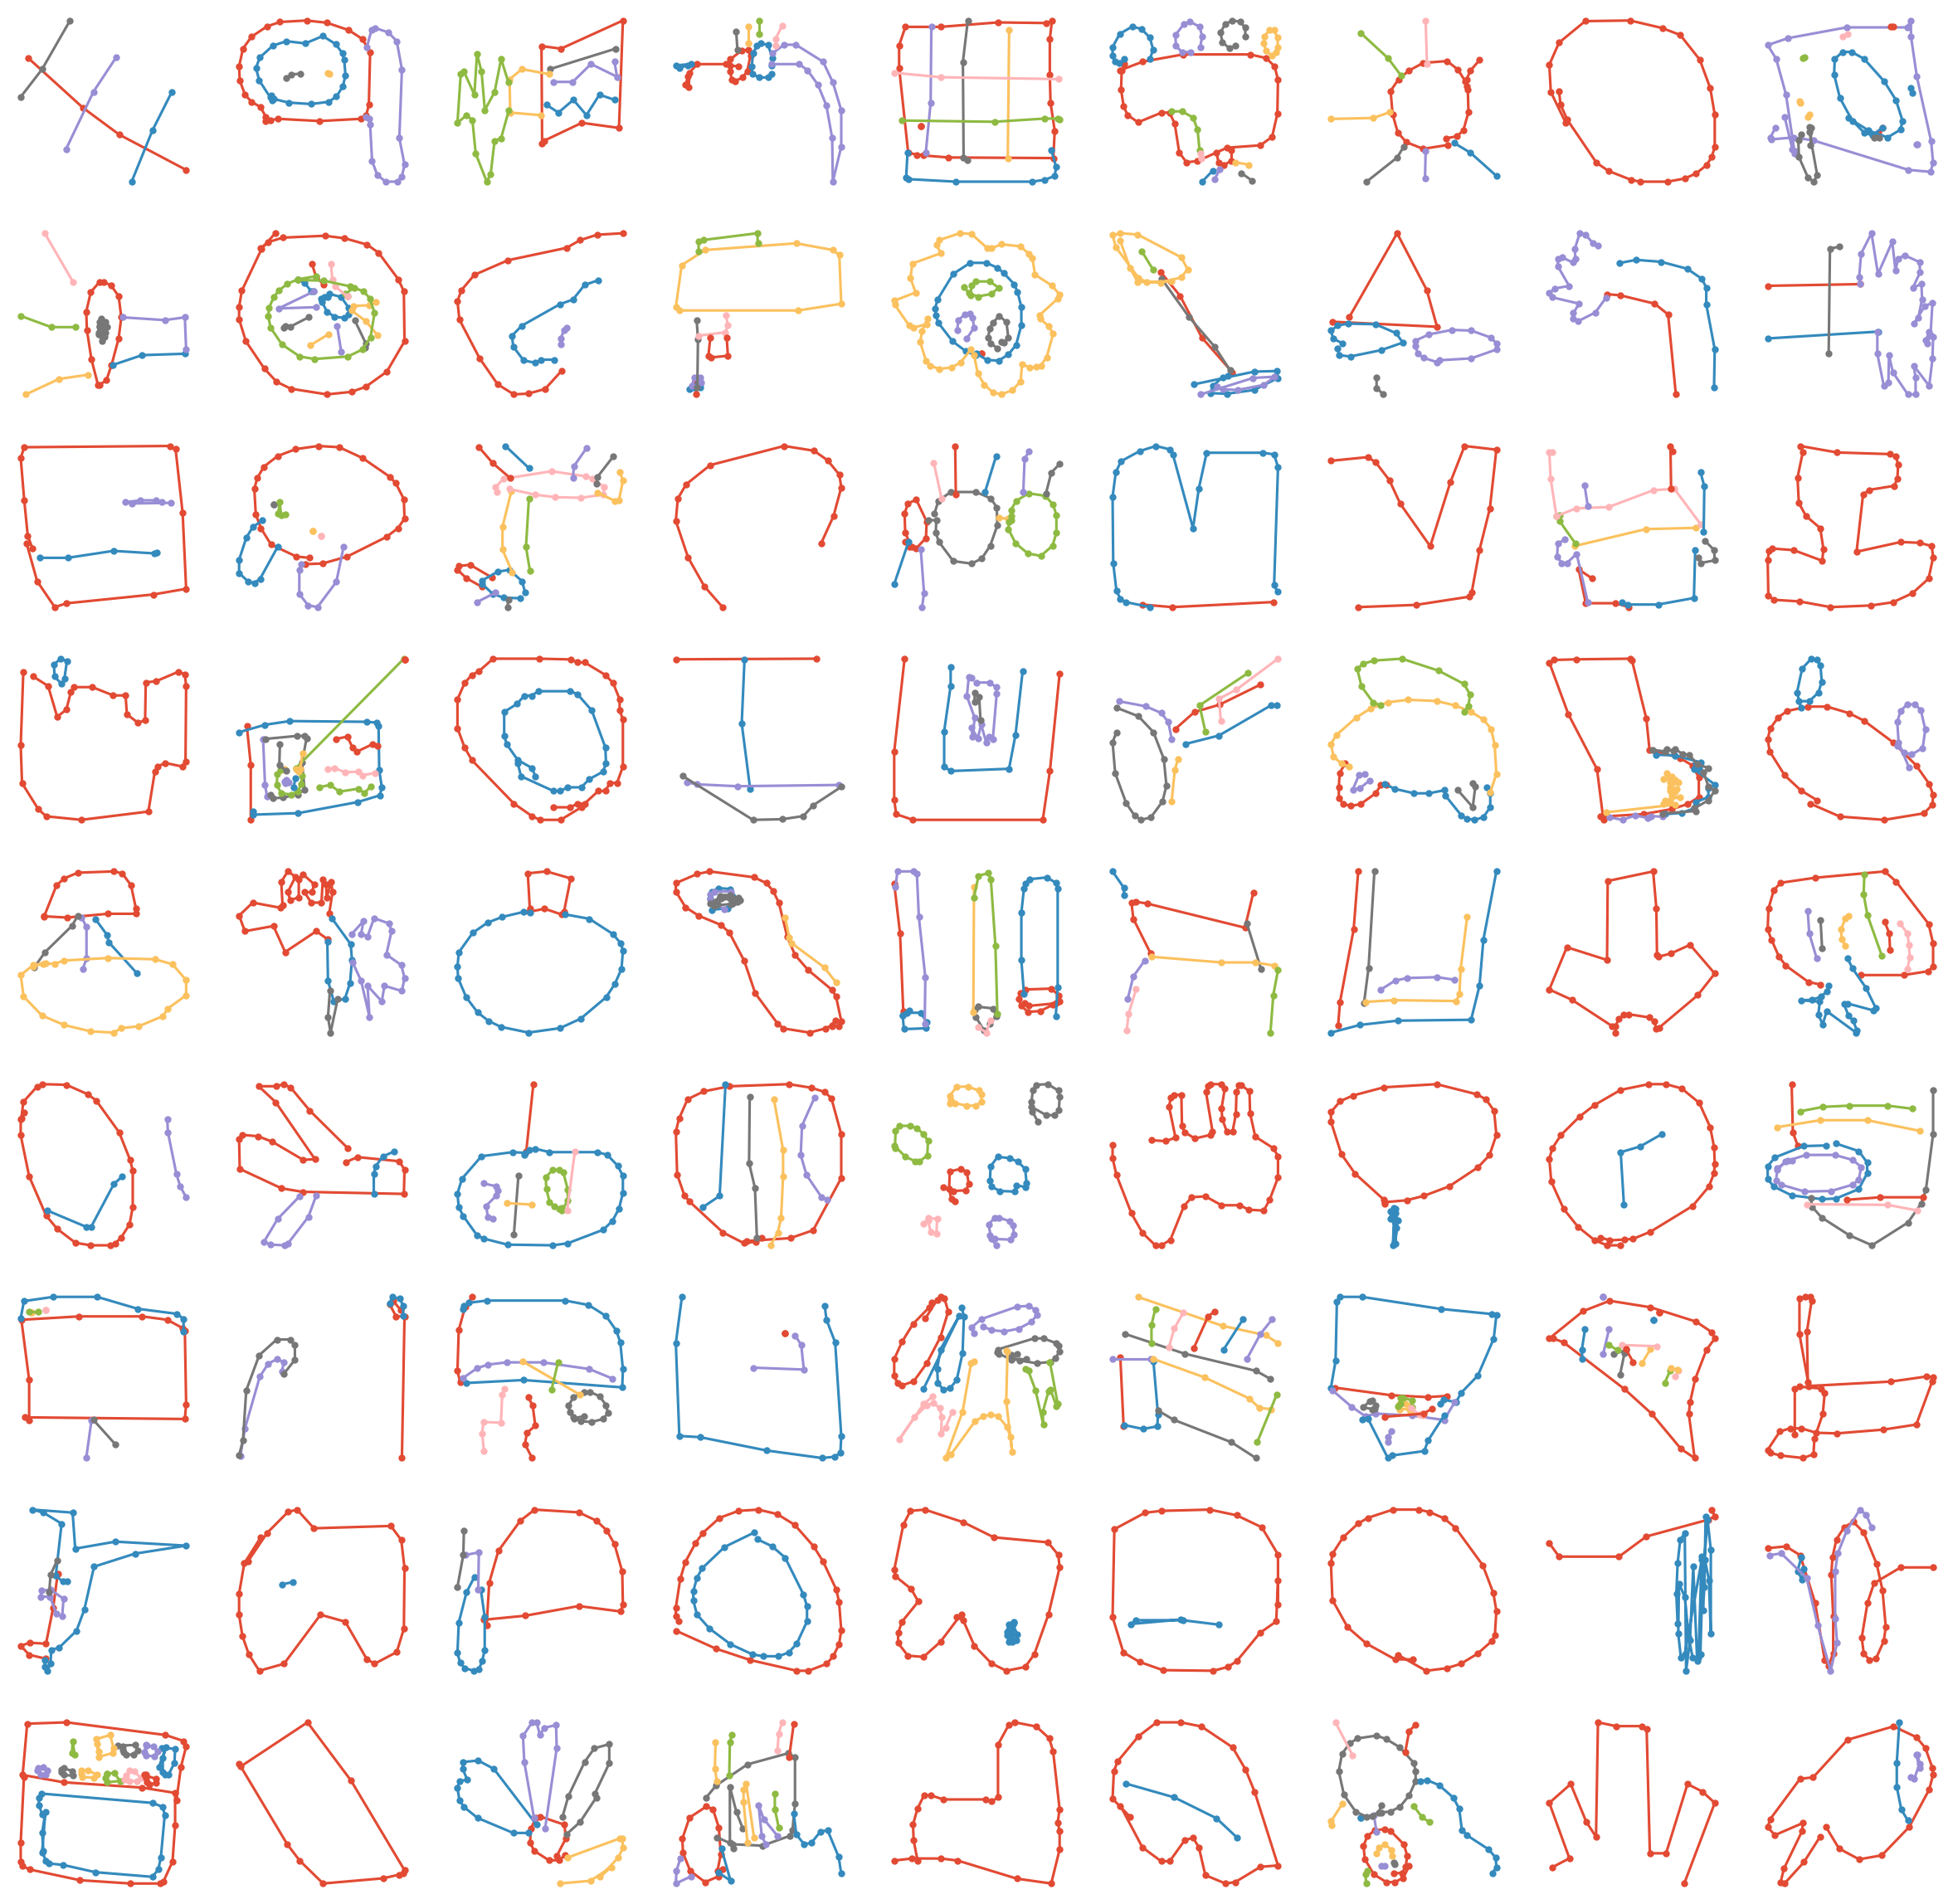

In [32]:
fig, m_axs = plt.subplots(9, 9, figsize = (20,20))
for f_dict, c_ax in zip(nd_gen, m_axs.flatten()):
    draw_dict(f_dict, c_ax, legend = False)
    c_ax.set_title('')
fig.savefig('overview.jpg', figdpi = 300)

In [33]:
n_strokes = []
stroke_length = []
total_length = []
for f_dict, _ in zip(nd_gen, range(512)):
    n_strokes += [len(f_dict['drawing'])]
    stroke_length += [len(x) for x,y in f_dict['drawing']]
    total_length += [sum([len(x) for x,y in f_dict['drawing']])]

Text(0.5, 1.0, 'Total Length')

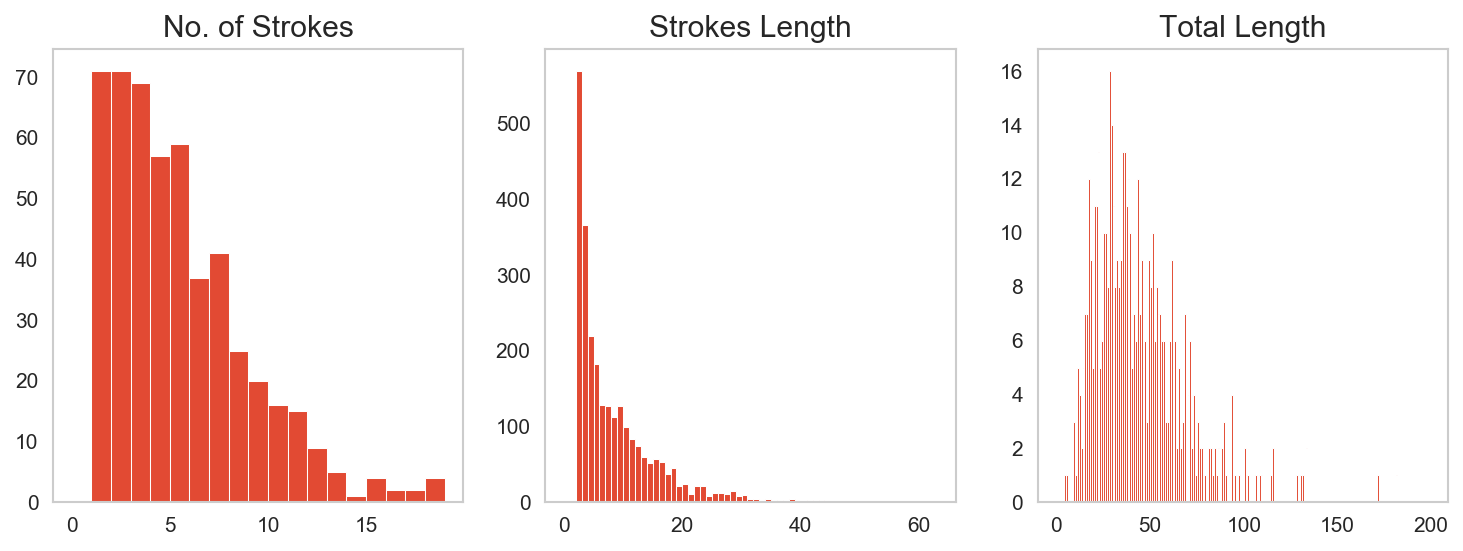

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.hist(n_strokes, np.arange(20))
ax1.set_title('No. of Strokes')
ax2.hist(stroke_length, np.arange(64))
ax2.set_title('Strokes Length')
ax3.hist(total_length, np.arange(200))
ax3.set_title('Total Length')

In [35]:
def drawing_to_array(in_drawing, max_length = 108):
    out_arr = np.zeros((max_length, 3), dtype = np.uint8) # x, y, indicator if it is a new stroke
    c_idx = 0
    for seg_label, (x_coord, y_coord) in enumerate(in_drawing):
        last_idx = min(c_idx + len(x_coord), max_length)
        seq_len = last_idx - c_idx
        out_arr[c_idx:last_idx, 0] = x_coord[:seq_len]
        out_arr[c_idx:last_idx, 1] = y_coord[:seq_len]
        out_arr[c_idx, 2] = 1 # indicate a new stroke
        c_idx = last_idx
        if last_idx>=max_length:
            break
    out_arr[:last_idx, 2] += 1
    return out_arr

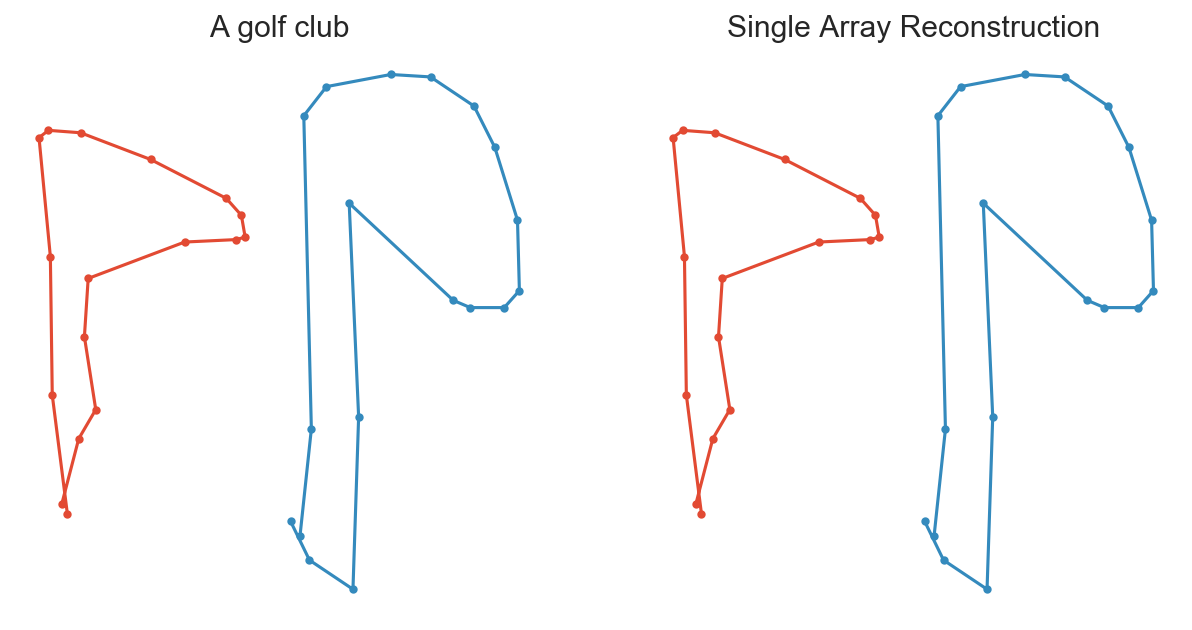

In [36]:
test_arr = drawing_to_array(f_dict['drawing'])
test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5))
draw_dict(f_dict, ax1, legend = False)
lab_idx = np.cumsum(test_arr[:,2]-1)
for i in np.unique(lab_idx):
    ax2.plot(test_arr[lab_idx==i,0], 
                test_arr[lab_idx==i,1], '.-')
ax2.axis('off')
ax2.set_title('Single Array Reconstruction');

In [37]:
!wc ../quickdraw_simplified/*.ndjson

wc: ../quickdraw_simplified/*.ndjson: open: No such file or directory


In [38]:
from tqdm import tqdm_notebook
out_blocks = []
for c_path in tqdm_notebook(obj_files, desc = 'File Progress'):
    for c_block in pd.read_json(c_path, lines = True, chunksize = 1500): # only take 1000
        # export as NHWC
        c_block['thumbnail'] = c_block['drawing'].map(lambda x: np.expand_dims(strokes_to_mat(x, rescale_dims = (128, 128)), -1))
        c_block.drop('drawing', inplace = True, axis = 1)
        out_blocks += [c_block]
        break

In [39]:
np.random.shuffle(out_blocks)
large_df = pd.concat(out_blocks, ignore_index=True) #index seems to c
del out_blocks
large_df.sample(5)

,countrycode,key_id,recognized,timestamp,word,thumbnail
22374,DE,5058804725055488,True,2017-01-23 11:43:50.845320,scorpion,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
194655,DE,5645264196993024,True,2017-01-16 11:00:02.845250,spreadsheet,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
113068,DE,5927787472879616,True,2017-01-26 18:29:00.133880,The Great Wall of China,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
139511,US,6083891817349120,True,2017-01-27 05:56:46.768810,strawberry,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
108855,AU,4539861170126848,False,2017-03-03 08:10:04.759350,cannon,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [20]:
import h5py
from tqdm import tqdm

def write_df_as_hdf(path,df,compression='gzip'):
    with h5py.File(path, 'w') as h:
        for k, arr_dict in tqdm(df.to_dict().items()):
            try:
                s_data = np.stack(arr_dict.values(), 0)
                try:
                    h.create_dataset(k, data=s_data, compression = compression)
                except TypeError as e:
                    try:
                        h.create_dataset(k, data=s_data.astype(np.string_),compression=compression)
                    except TypeError as e2:
                        print('%s could not be added to hdf5, %s' % (
                            k, repr(e), repr(e2)))
            except ValueError as e:
                print('%s could not be created, %s' % (k, repr(e)))
                all_shape = [np.shape(x) for x in arr_dict.values()]
                warn('Input shapes: {}'.format(all_shape))

In [21]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(large_df, random_state = 26, test_size = 0.20, stratify = large_df['word'])

del large_df

train_df, valid_df = train_test_split(train_df, random_state = 26, test_size = 0.33, stratify = train_df['word'])
print('Training', train_df.shape[0], 
      'Valid', valid_df.shape[0], 
      'Test', test_df.shape[0])

Training 277380 Valid 136620 Test 103500


In [36]:
train_df = train_df[train_df['recognized'] == True]
valid_df = valid_df[valid_df['recognized'] == True]
test_df = test_df[test_df['recognized'] == True]

In [37]:
#write_df_as_hdf('quickdraw_train.h5', train_df)
#write_df_as_hdf('quickdraw_valid.h5', valid_df)
#write_df_as_hdf('quickdraw_test.h5', test_df)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/shloakgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':
100%|██████████| 7/7 [01:08<00:00, 14.32s/it]


In [38]:
# show what is inside
with h5py.File('quickdraw_train.h5', 'r') as h5_data:
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

countrycode (254517,) |S2
key_id (254517,) int64
recognized (254517,) bool
strokes (254517, 108, 3) uint8
thumbnail (254517, 128, 128, 1) float32
timestamp (254517,) |S26
word (254517,) |S23


In [39]:
np.stack(valid_df['thumbnail'].values,0).shape

(125275, 128, 128, 1)

In [22]:
#np.shape(list(train_df.to_dict().values())[-3])

()

In [23]:
#for k, arr_dict in tqdm(train_df.to_dict().items()):
#    print(k, np.shape(list(arr_dict.values())))

 14%|█▍        | 1/7 [00:00<00:00,  9.42it/s]

countrycode (277380,)
key_id (277380,)
recognized (277380,)


 71%|███████▏  | 5/7 [00:00<00:00,  8.71it/s]

timestamp (277380,)
word (277380,)


 86%|████████▌ | 6/7 [00:01<00:00,  2.91it/s]

thumbnail (277380, 28, 28, 1)


100%|██████████| 7/7 [00:01<00:00,  2.88it/s]

strokes (277380, 108, 3)


In [30]:
train_df.head()

,countrycode,key_id,recognized,timestamp,word,thumbnail,strokes
387622,DZ,4612664439341056,True,2017-03-14 20:10:45.842250,umbrella,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[4, 96, 2], [9, 74, 1], [25, 41, 1], [40, 26,..."
362569,AU,5815072024690688,True,2017-03-13 04:12:49.312460,underwear,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[4, 2, 2], [37, 2, 1], [148, 19, 1], [236, 19..."
236609,CH,6620468524089344,True,2017-01-27 21:46:26.636290,grapes,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[98, 0, 2], [98, 87, 1], [90, 49, 1], [90, 26..."
151040,GB,4556583725957120,True,2017-03-05 15:40:57.453610,flower,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[123, 90, 2], [118, 83, 1], [108, 79, 1], [91..."
234509,EG,4680512675250176,True,2017-03-26 17:35:22.293120,fish,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[0, 21, 2], [11, 112, 1], [47, 66, 1], [93, 2..."


In [26]:
train_df['thumbnail1'] = train_df['thumbnail'].apply(lambda x: x.flatten())

In [27]:
train_df.reset_index()

,index,countrycode,key_id,recognized,timestamp,word,thumbnail,strokes,thumbnail1
0,27622,DZ,4612664439341056,True,2017-03-14 20:10:45.842250,umbrella,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[4, 96, 2], [9, 74, 1], [25, 41, 1], [40, 26,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,490069,AU,5815072024690688,True,2017-03-13 04:12:49.312460,underwear,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[4, 2, 2], [37, 2, 1], [148, 19, 1], [236, 19...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,383609,CH,6620468524089344,True,2017-01-27 21:46:26.636290,grapes,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[98, 0, 2], [98, 87, 1], [90, 49, 1], [90, 26...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00027088274, ..."
3,163040,GB,4556583725957120,True,2017-03-05 15:40:57.453610,flower,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [-...","[[123, 90, 2], [118, 83, 1], [108, 79, 1], [91...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.005800954, 0..."
4,350009,EG,4680512675250176,True,2017-03-26 17:35:22.293120,fish,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[0, 21, 2], [11, 112, 1], [47, 66, 1], [93, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,355674,US,5338251483152384,True,2017-03-26 16:59:23.586680,coffee cup,"[[[0.1262474], [0.03574196], [0.044401366], [0...","[[18, 115, 2], [0, 237, 1], [0, 253, 1], [3, 2...","[0.1262474, 0.03574196, 0.044401366, 0.0432135..."
6,454392,US,6648755795263488,True,2017-03-27 05:21:30.206760,couch,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[38, 10, 2], [38, 78, 1], [46, 99, 1], [65, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,145013,SA,4651141843386368,True,2017-03-16 14:14:39.169610,chair,"[[[8.9953435e-05], [-0.004444116], [0.03144709...","[[88, 0, 2], [87, 52, 1], [79, 126, 1], [82, 1...","[8.9953435e-05, -0.004444116, 0.031447094, 0.0..."
8,68905,US,6612355226009600,True,2017-03-02 02:41:17.284440,finger,"[[[-0.0005769321], [5.0094644e-05], [0.0], [0....","[[18, 21, 2], [6, 94, 1], [1, 186, 1], [1, 244...","[-0.0005769321, 5.0094644e-05, 0.0, 0.0, 0.0, ..."
9,314848,US,5681001197993984,True,2017-03-09 19:26:59.465650,fork,"[[[0.013900518], [0.09609224], [0.1109396], [0...","[[8, 102, 2], [13, 121, 1], [13, 160, 1], [1, ...","[0.013900518, 0.09609224, 0.1109396, 0.0870125..."


In [28]:
df1 = pd.DataFrame(train_df['thumbnail1'].values.tolist())

In [29]:
df1['label'] = train_df['word'].values

In [30]:
df1['countrycode'] = train_df['countrycode'].values

In [31]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,label,countrycode
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.058180,0.036038,-0.001797,-0.004482,0.000117,0.000010,0.00000,0.000000,umbrella,DZ
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,-0.005072,-0.005072,-0.005072,-0.005044,-0.005383,-0.005533,-0.00133,-0.000992,underwear,AU
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000271,-0.007779,0.064763,0.141614,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,grapes,CH
3,0.0,0.0,0.0,0.0,0.0,0.0,-0.005801,0.051430,0.056413,-0.006717,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,flower,GB
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.110887,0.047334,0.004577,-0.004860,-0.000580,0.000077,0.00000,0.000000,fish,EG


In [32]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import seaborn as sns

In [1]:
X_train = df1.drop(['label', 'countrycode'], axis=1)

NameError: name 'df1' is not defined

In [34]:
Y_train = df1['label']

# Principal Component Analysis 

0.8996025536890765

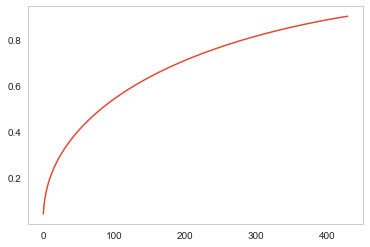

In [35]:

pca = decomposition.PCA(n_components=430)
pca.fit(X_train)
#pca.explained_variance_ratio_.cumsum()
plt.plot(pca.explained_variance_ratio_.cumsum())
pca.explained_variance_ratio_.cumsum()[-1]

In [36]:
X_train = pca.transform(X_train)

## Naive Bayes 

In [37]:
modelNB = GaussianNB()
modelNB.fit(X_train,Y_train)
prediction = cross_val_predict(modelNB, X_train, Y_train, cv = 5)

In [38]:
print("Accuracy={}".format(metrics.accuracy_score(Y_train, prediction)))

## Random Forrest

In [ ]:
# modelRF = RandomForestClassifier(n_estimators = 100,  
#                                max_features = 'sqrt',
#                                n_jobs=-1, verbose = 1)
# modelRF.fit(X_train,Y_train)
# prediction = cross_val_predict(modelRF, X_train, Y_train, cv = 3)
# cm = metrics.confusion_matrix(Y_train, prediction)
# print("Accuracy={}".format(metrics.accuracy_score(Y_train, prediction)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.6min
